# Graph testing
This is a notebook that can be used to play around with graphs and get instant feedback (instead of passing it to html and running the server.)

It was tricky to get Jupyter to run Django, and I hope it is reproducible.  To run this, Jupyter must be launched from within pipenv.  And while there might be a way to run a notebook in a subdirectory, I could only get it to work when the notebook is in the root folder.

## Setup code

In [1]:
import os, sys
configuration = os.getenv('ENVIRONMENT', 'development').title()
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'planningportal.settings')
os.environ.setdefault('DJANGO_CONFIGURATION', configuration)
from configurations.management import execute_from_command_line
import django
django.setup()

In [2]:
if 'ppts.views' in sys.modules:
    del sys.modules['ppts.views'] 
from ppts.views import *

%matplotlib inline

In [3]:
import pandas as pd
import datetime
from django.db.models import Q
from django.db.models import F

## Record statuses

In [56]:
def pie_from_counts(query, label_key, counts_key):
    '''Generates a pie chart from a query, and returns DataFrame with results.'''
    counts = []
    labels = []
    for item in query:
        labels.append(item[label_key])
        counts.append(item[counts_key])
    fig,ax = plt.subplots(figsize=(4,4))
    plt.show(ax.pie(counts, labels=labels))
    
    counts_table = pd.DataFrame({'label':labels,'counts':counts})
    return counts_table

In [260]:
projects = Record.objects.filter(record_type__pk = 'PRJ').values('status').annotate(status_counts = Count('pk'))
print(projects)

<QuerySet [{'status_counts': 251, 'status': 'Accepted'}, {'status_counts': 1, 'status': 'Actions Pending'}, {'status_counts': 330, 'status': 'Application Accepted'}, {'status_counts': 6, 'status': 'Approved'}, {'status_counts': 36689, 'status': 'Closed'}, {'status_counts': 12, 'status': 'Closed - Approved'}, {'status_counts': 1, 'status': 'Closed - Complete'}, {'status_counts': 141, 'status': 'Closed - Withdrawn'}, {'status_counts': 7, 'status': 'Complete'}, {'status_counts': 1, 'status': 'Denied'}, {'status_counts': 1, 'status': 'Disapproved'}, {'status_counts': 1, 'status': 'Incomplete'}, {'status_counts': 14, 'status': 'On Hold'}, {'status_counts': 226, 'status': 'Open'}, {'status_counts': 14, 'status': 'Pending'}, {'status_counts': 1, 'status': 'Pending Review'}, {'status_counts': 47, 'status': 'Submitted'}, {'status_counts': 1938, 'status': 'Under Review'}, {'status_counts': 573, 'status': 'Withdrawn'}, {'status_counts': 114, 'status': 'nan'}]>


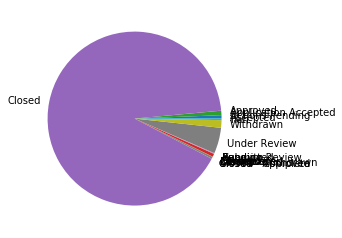

    counts                 label
0      251              Accepted
1        1       Actions Pending
2      330  Application Accepted
3        6              Approved
4    36689                Closed
5       12     Closed - Approved
6        1     Closed - Complete
7      141    Closed - Withdrawn
8        7              Complete
9        1                Denied
10       1           Disapproved
11       1            Incomplete
12      14               On Hold
13     226                  Open
14      14               Pending
15       1        Pending Review
16      47             Submitted
17    1938          Under Review
18     573             Withdrawn
19     114                   nan
Total number of records: 40368


In [129]:
#pie chart for all projects
projects = Record.objects.filter(record_type__pk = 'PRJ').values('status').annotate(status_counts = Count('pk'))
table = pie_from_counts(projects,'status','status_counts')
print(table)
print('Total number of records: %s' % table['counts'].sum())

Here's the problem: "Closed" includes records whose status is unknown, even to the planning department!  They say that some of these come from legacy records, where the status could not be accurately determined.  I think some of them have been approved, but it's lumped together in a way that we're not actually sure.  (Note: "Accepted" does not mean "approved" and just means the application met minimum requirements to begin consideration.)

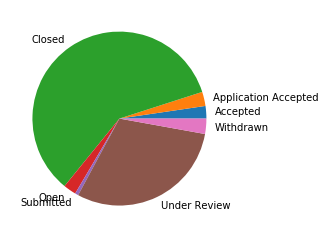

   counts                 label
0      45              Accepted
1      51  Application Accepted
2    1145                Closed
3      46                  Open
4      12             Submitted
5     581          Under Review
6      55             Withdrawn
Total number of records: 1935


In [137]:
#Limit to projects from 2018
projects = Record.objects.filter(record_type__pk = 'PRJ').filter(
    date_opened__lt=datetime.date(2019, 1, 1), date_opened__gt=datetime.date(2018, 1, 1)
    ).values('status').annotate(status_counts = Count('pk'))
table = pie_from_counts(projects,'status','status_counts')
print(table)
print('Total number of records: %s' % table['counts'].sum())

In [162]:
print(projects.query)

SELECT "ppts_record"."status", COUNT("ppts_record"."id") AS "status_counts" FROM "ppts_record" INNER JOIN "ppts_projectfeature" ON ("ppts_record"."id" = "ppts_projectfeature"."record_id") WHERE ("ppts_record"."record_type_id" = PRJ AND (("ppts_projectfeature"."net" > 0 AND "ppts_projectfeature"."type" = MARKET_RATE) OR ("ppts_projectfeature"."net" > 0 AND "ppts_projectfeature"."type" = AFFORDABLE)) AND "ppts_record"."date_opened" > 2018-01-01 AND "ppts_record"."date_opened" < 2019-01-01) GROUP BY "ppts_record"."status"


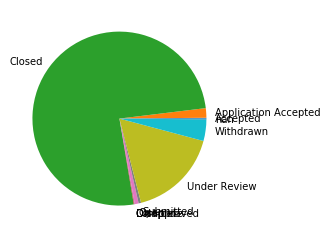

    counts                 label
0        3              Accepted
1       35  Application Accepted
2     1497                Closed
3        2              Complete
4        1           Disapproved
5        1               On Hold
6       14                  Open
7        9             Submitted
8      333          Under Review
9       79             Withdrawn
10       3                   nan
Total number of records: 1977


In [164]:
#limit to projects that increase the number of market rate units OR affordable units
projects = Record.objects.filter(record_type__pk = 'PRJ').filter(
    Q(projectfeature__type=ProjectFeature.MARKET_RATE, projectfeature__net__gt=0) |
    Q(projectfeature__type=ProjectFeature.AFFORDABLE, projectfeature__net__gt=0) 
    ).values('status').annotate(status_counts = Count('pk',distinct=True))
#note the 'distinct' parameter is set to True, which is necessary because 
#there's an implicit join between tables that duplicates some of the entries of the Record table.
table = pie_from_counts(projects,'status','status_counts')
print(table)
print('Total number of records: %s' % table['counts'].sum())

I'd like to try finding more information about projects by looking at related (parent & child) records.  But first, we need to characterize this aspect of the data.  How many PRJ records even have children or parents?  What kind of records are the children and parents?

In [317]:
project_parents = Record.parent.through.objects.filter(from_record__record_type__pk = 'PRJ').filter(
    Q(from_record__projectfeature__type=ProjectFeature.MARKET_RATE, from_record__projectfeature__net__gt=0) |
    Q(from_record__projectfeature__type=ProjectFeature.AFFORDABLE, from_record__projectfeature__net__gt=0) ).distinct()

#This is the count of parent-child relationships where the child is a housing project
print(project_children.count())

7


In [318]:
project_parents = Record.parent.through.objects.filter(to_record__record_type__pk = 'PRJ').filter(
    Q(to_record__projectfeature__type=ProjectFeature.MARKET_RATE, to_record__projectfeature__net__gt=0) |
    Q(to_record__projectfeature__type=ProjectFeature.AFFORDABLE, to_record__projectfeature__net__gt=0) ).distinct()

#This is the count of parent-child relationships where the parent is a housing project
print(project_parents.count())

1485


## Potential database issues
Just noting some database issues as I run into them.

### Parent-child relationship (resolved)
Resolution: Modified the parent ManyToManyField to include the parameter `symmetrical=False`.  The database now works as intended.

For some reason the parent-child relationship doesn't work entirely correctly.

The Record model includes a ManyToMany relationship to itself, where each record includes a list of all parents.  Given a particular record, it is possible to get all the parents, and it is possible to filter on the properties of the parents.

In [4]:
#get all parents of a record
r = Record.objects.get(pk=109391)
print(r.parent.all())

<QuerySet [<Record: Record object (90111)>]>


In [5]:
#filter on properties of parent
q = Record.objects.filter(parent__pk=109391)
print(q)

<QuerySet [<Record: Record object (1171)>]>


It should also be possible to perform the reverse operations, using the `related_name` parameter of the ManyToManyField.  In the Record model, the `related_name` parameter is set to 'child'.  However, operations using the keyword 'child' are not recognized.

In [6]:
Record._meta.get_fields()

(<ManyToManyRel: ppts.record>,
 <ManyToOneRel: ppts.landuse>,
 <ManyToOneRel: ppts.projectfeature>,
 <ManyToOneRel: ppts.dwellingtype>,
 <django.db.models.fields.IntegerField: id>,
 <django.db.models.fields.related.ForeignKey: planner>,
 <django.db.models.fields.related.ForeignKey: location>,
 <django.db.models.fields.related.ForeignKey: record_type>,
 <django.db.models.fields.CharField: record_id>,
 <django.db.models.fields.IntegerField: object_id>,
 <django.db.models.fields.CharField: template_id>,
 <django.db.models.fields.CharField: name>,
 <django.db.models.fields.TextField: description>,
 <django.db.models.fields.CharField: status>,
 <django.db.models.fields.FloatField: construct_cost>,
 <django.db.models.fields.CharField: related_building_permit>,
 <django.db.models.fields.TextField: acalink>,
 <django.db.models.fields.TextField: aalink>,
 <django.db.models.fields.DateField: date_opened>,
 <django.db.models.fields.DateField: date_closed>,
 <django.db.models.fields.CharField: mcd

In [8]:
#try filtering on properties of child
q = Record.objects.filter(child__pk=109391)
print(q)

<QuerySet [<Record: Record object (90111)>]>


What *is* possible, is querying the through table.

In [9]:
#Query the through table, and filter out all entries where the child field is 109391
rel = Record.parent.through.objects.filter(from_record=109391)
#print out the parent field for the first such entry
print(rel[0].to_record)

Record object (90111)


In [10]:
#Query the through table, and filter out all entries where the parent field is 109391
rel = Record.parent.through.objects.filter(from_record=109391)
#print out the child field for the first such entry
print(rel[0].from_record)

Record object (109391)


In conclusion, the relevant information is in the database, but for some reason the queries using `related_name` do not work properly.  I suspect it may be a problem in the construction of the database